# Fourth assignment: Network Robustness

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

## 0. Failure utilities

In [70]:
def execute_failures(graph, failureList):
    workingG = graph.copy()
    giant = max(nx.connected_component_subgraphs(workingG), key=len)
    diam_evol = [nx.diameter(giant)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(giant)]
    
    for node,_ in failureList:
        workingG.remove_node(node)
        if len(workingG)==0: break
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        giant = max(nx.connected_component_subgraphs(workingG), key=len)
        if deg_evol[-1]>=1:
            giant_evol.append(len(giant))
            diam_evol.append(nx.diameter(giant))
        else:
            giant_evol.append(0)
            diam_evol.append(0)
            
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def plot_distribution(failDict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle("{} failures evolution".format(title))
 
    plt.subplot(121)
    plt.plot(failDict["Diameter evolution"], label="Diameter evolution")
    plt.plot(failDict["Average degree evolution"], label="Average degree evolution")
    plt.xlabel("#failures")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    
    plt.subplot(122)
    plt.plot(failDict["Giant component evolution"], label="Giant component evolution")
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    plt.legend()
    plt.grid()
    
def compare_attack(failDict, network):
    plt.figure(figsize=(15,8))
    plt.title("Evolution Comparison between different attack in a {} graph".format(network))
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    for attack, evolution in failDict.items():
        plt.plot(evolution, label=attack)
    plt.legend()
    plt.grid()
    
def compare_attack2(failDict, network):
    title = "Evolution Comparison between different attack in a {} graph".format(network)
    
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="#failures")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="GC size")
        )
    )
    
    data = []
    for attack, evolution in failDict.items():
        trace = go.Scatter(
            y=evolution,
            name=attack,
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

In [71]:
def random_ranking(graph):
    return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))

def metric_ranking(metricFunction, graph, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return sorted(metricDict.items(), key=lambda pair:pair[1], reverse=True)

## 1. Erdős-Rényi random graph [$G_{np}$]
<h4><li>$p>\frac{\log{n}}{n}$ </li></h4>

In [72]:
n = 100
attackDict = {}

In [73]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=5.24


/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



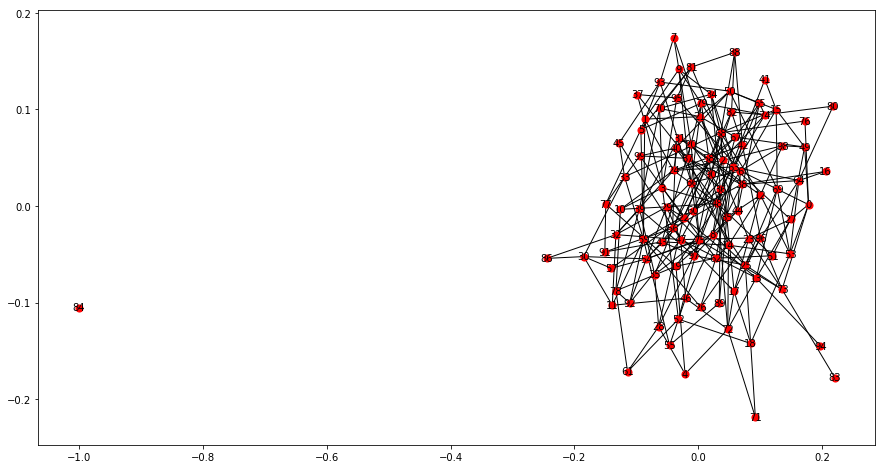

In [74]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [75]:
randomList = random_ranking(G)
#randomList

In [76]:
rand_failures = execute_failures(G, randomList)

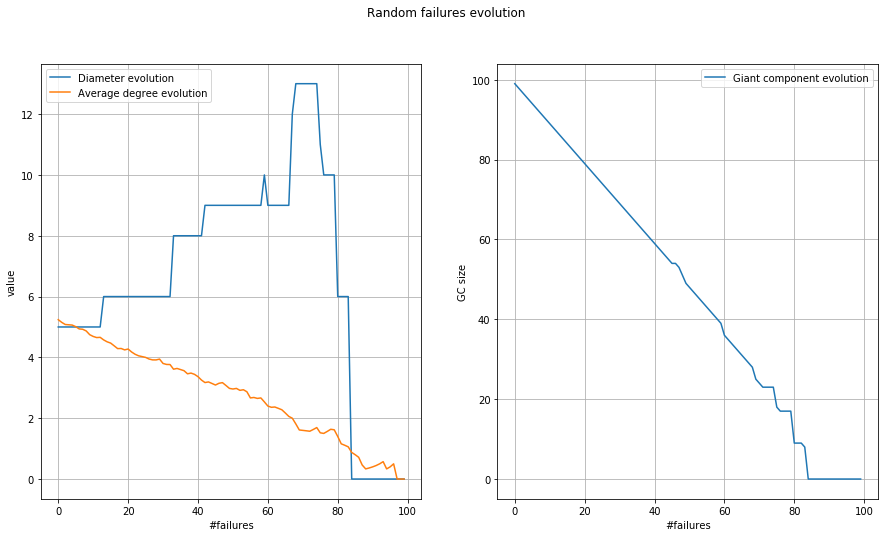

In [77]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [78]:
degList = metric_ranking(nx.degree, G)
#degList

In [79]:
deg_failures = execute_failures(G, degList)

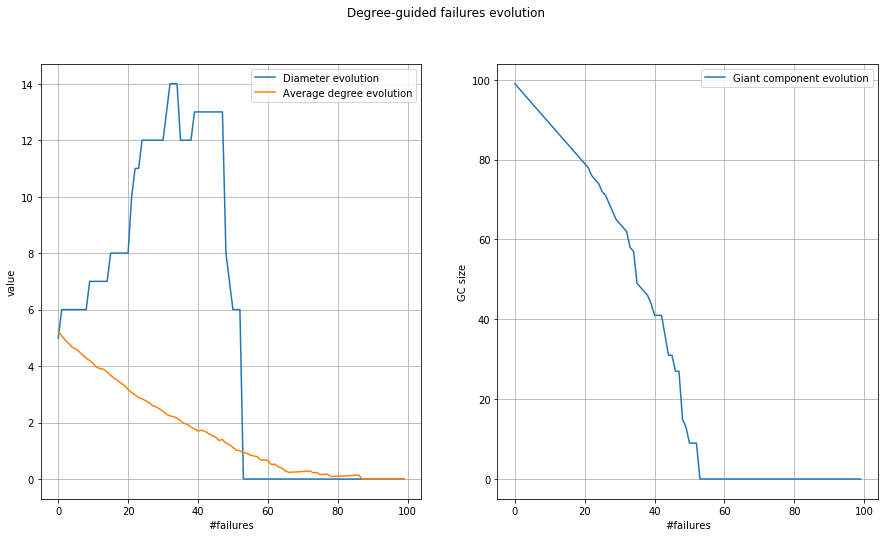

In [80]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over closeness

In [81]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [82]:
cls_failures = execute_failures(G, clsList)

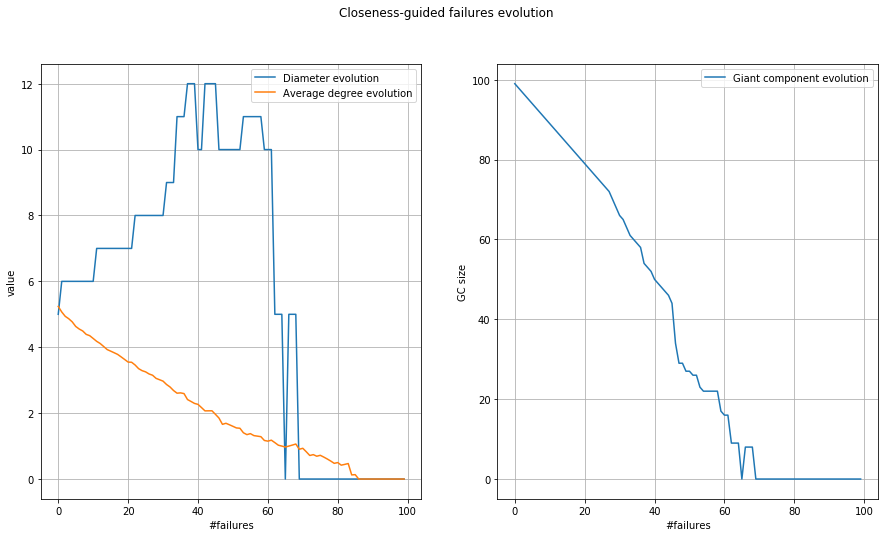

In [83]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [84]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [85]:
btw_failures = execute_failures(G, btwList)

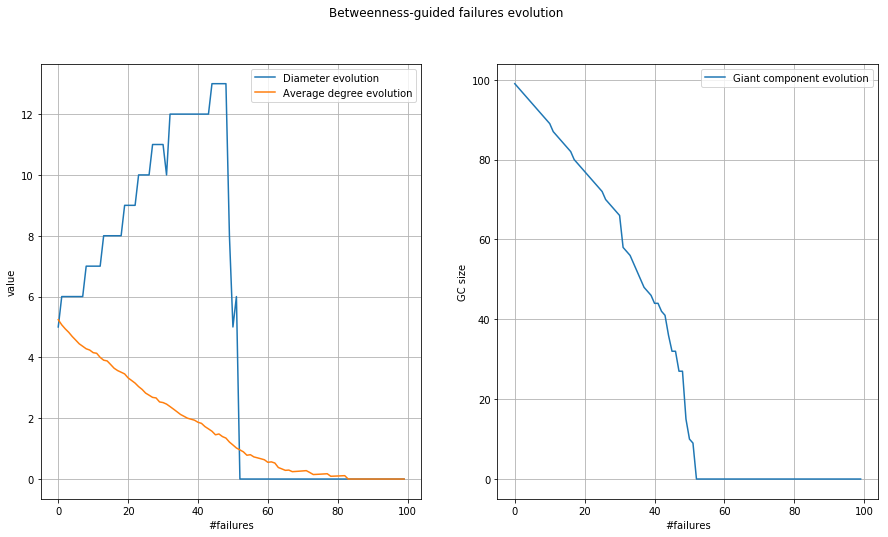

In [86]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [87]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [88]:
clt_failures = execute_failures(G, cltList)

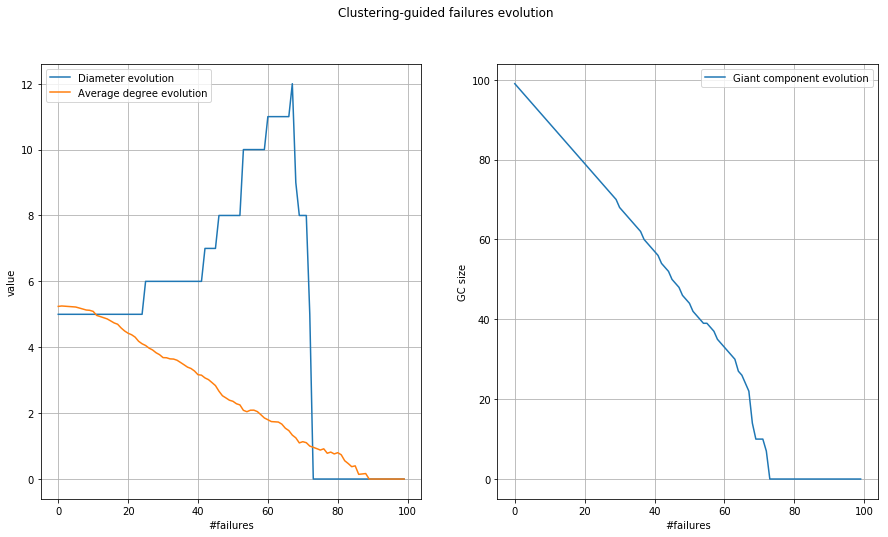

In [89]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [90]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [91]:
prk_failures = execute_failures(G, prkList)

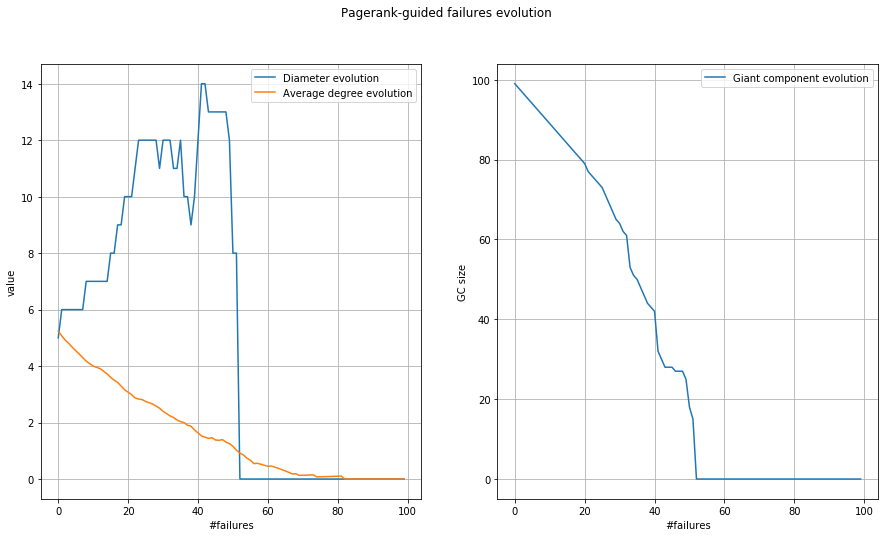

In [92]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [93]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

In [94]:
hit_failures = execute_failures(G, hitList)

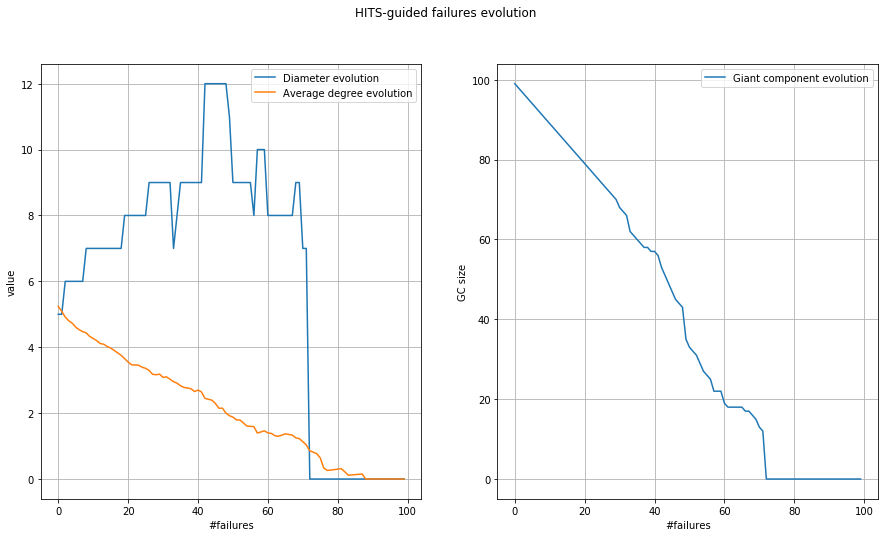

In [95]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

In [96]:
compare_attack(attackDict, "Random")

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## 2. Power law network

In [97]:
n = 100
attackDict = {}

In [98]:
G = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(G)
print("<k>={}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

<k>=3.92


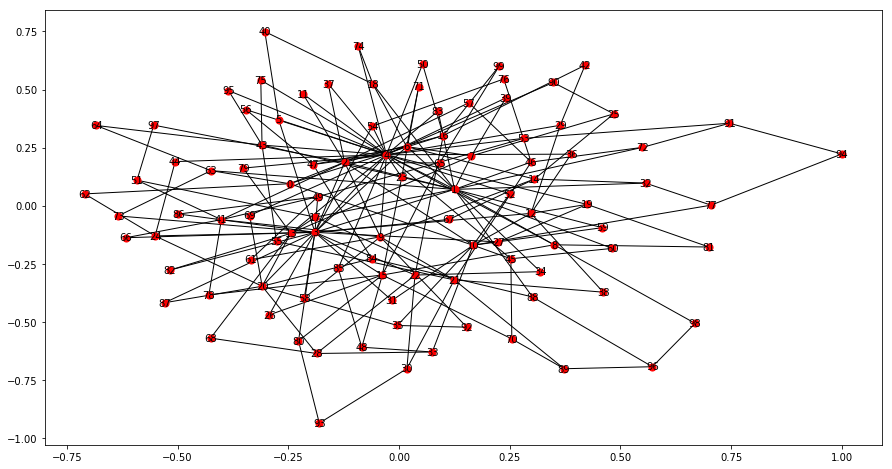

In [99]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [100]:
randomList = random_ranking(G)
#randomList

In [101]:
rand_failures = execute_failures(G, randomList)

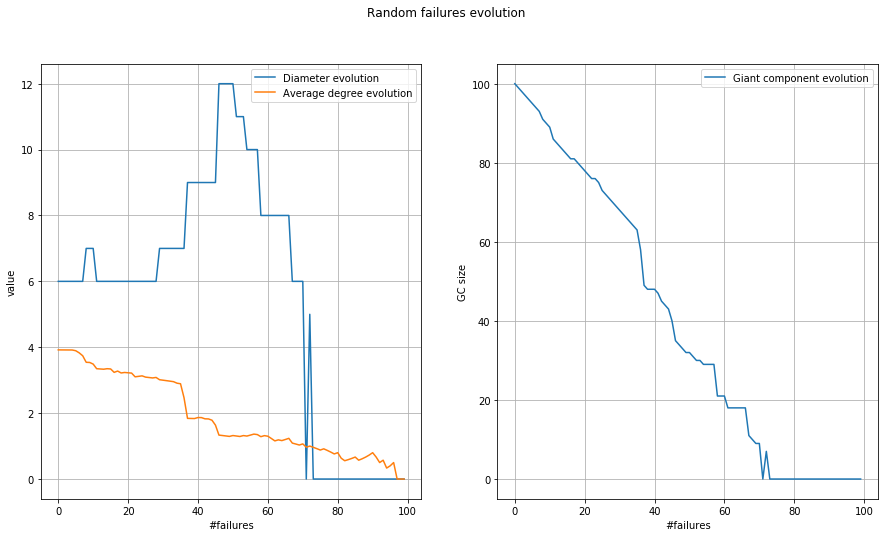

In [102]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [103]:
degList = metric_ranking(nx.degree, G)
#degList

In [104]:
deg_failures = execute_failures(G, degList)

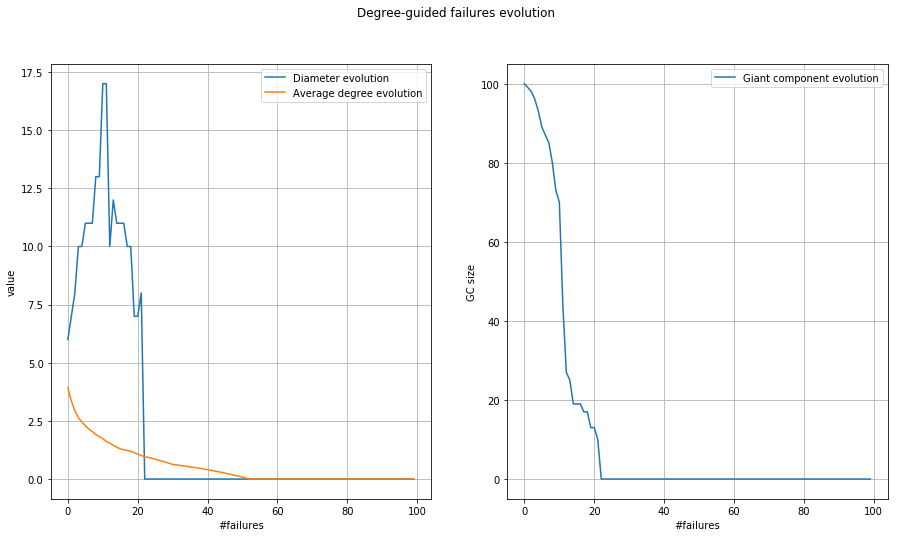

In [105]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over closeness

In [106]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [107]:
cls_failures = execute_failures(G, clsList)

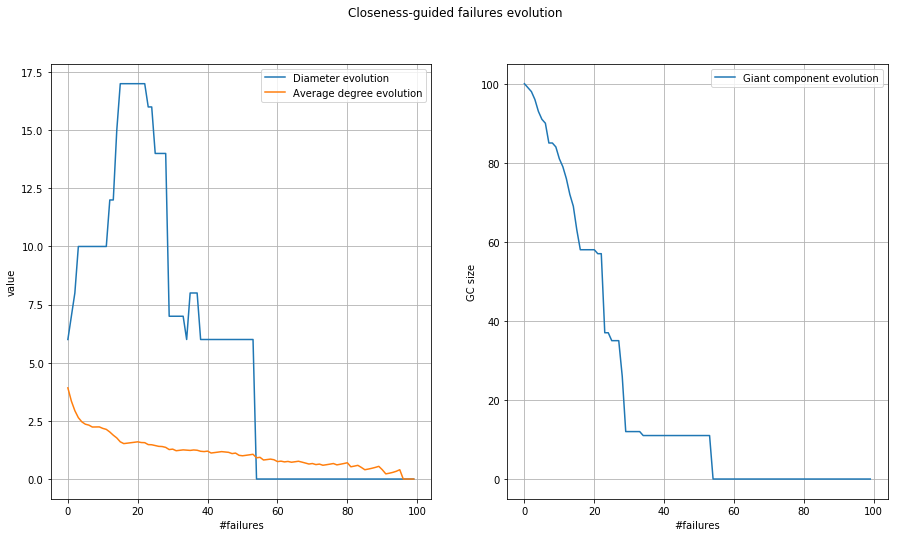

In [108]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [109]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [110]:
btw_failures = execute_failures(G, btwList)

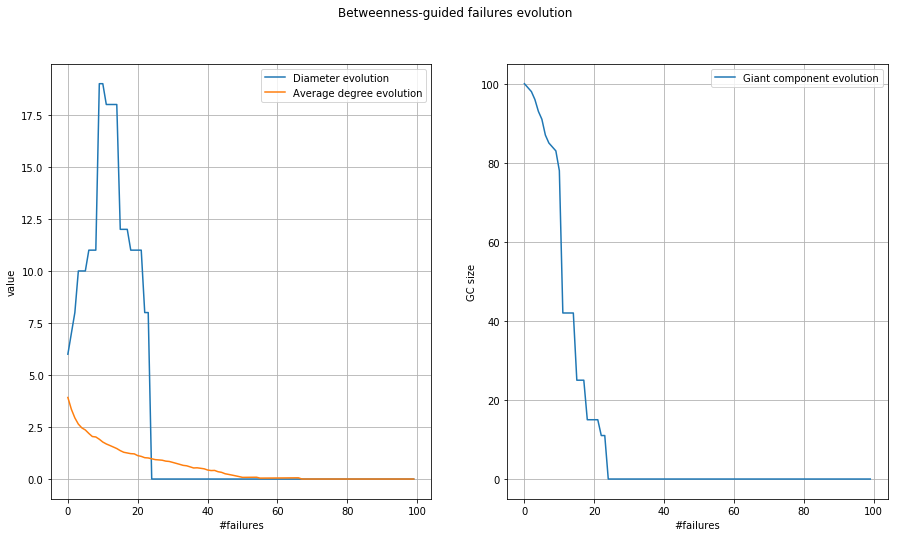

In [111]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [112]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [113]:
clt_failures = execute_failures(G, cltList)

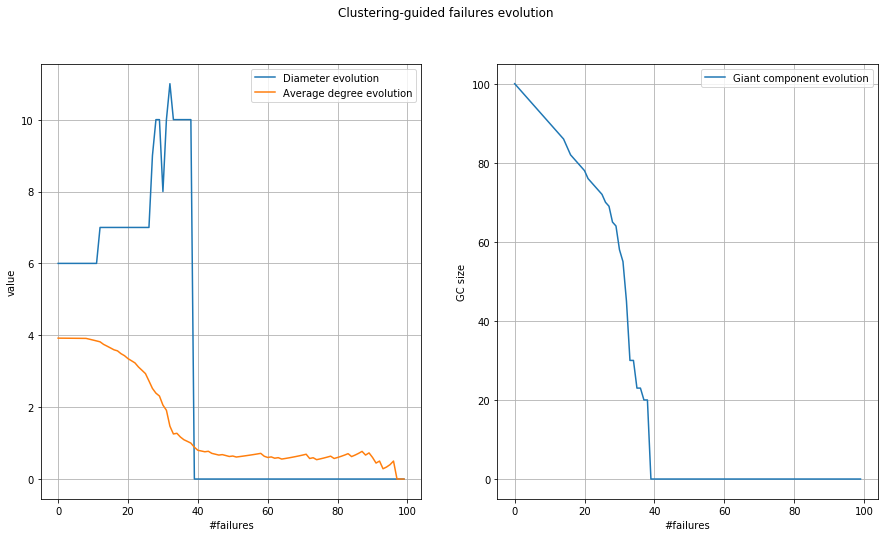

In [114]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [115]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [116]:
prk_failures = execute_failures(G, prkList)

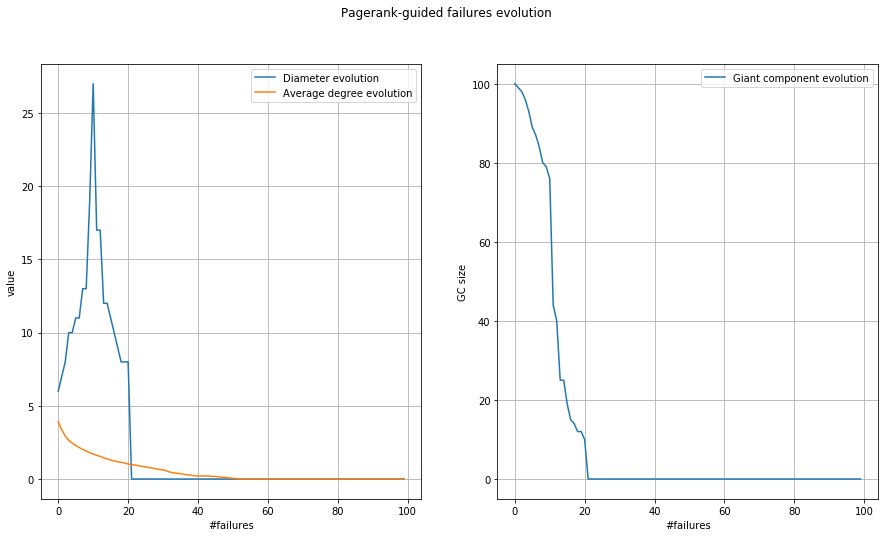

In [117]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [118]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning:

Casting complex values to real discards the imaginary part



In [119]:
hit_failures = execute_failures(G, hitList)

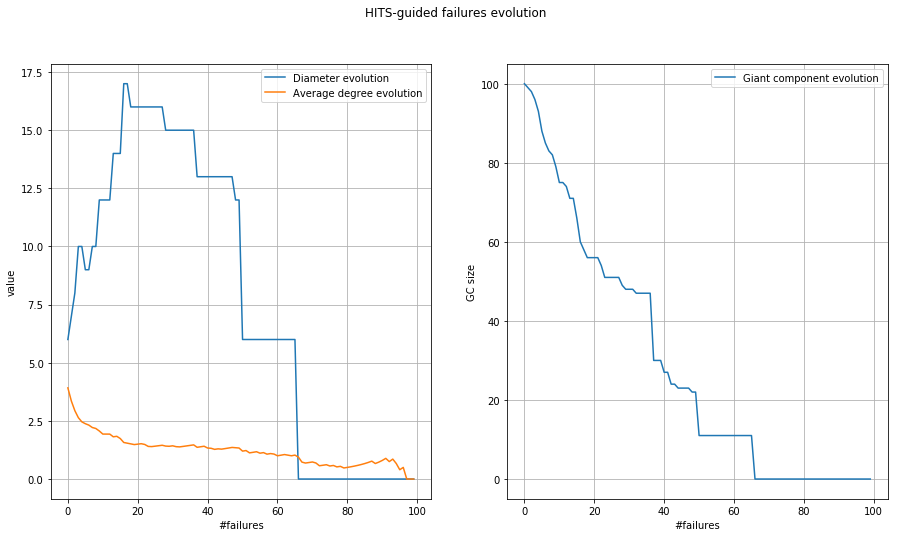

In [120]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

In [121]:
compare_attack(attackDict, "power-law")

## 3. Real Graph - arXiv collaboration on general relativity

In [ ]:
attackDict = {}

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random failures

In [ ]:
randomList = random_ranking(G)
#randomList

In [ ]:
rand_failures = execute_failures(G, randomList)

In [ ]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [ ]:
degList = metric_ranking(nx.degree, G)
#degList

In [ ]:
deg_failures = execute_failures(G, degList)

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over closeness

In [ ]:
clsList = metric_ranking(nx.closeness_centrality, G)
#clsList

In [ ]:
cls_failures = execute_failures(G, clsList)

In [ ]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [ ]:
btwList = metric_ranking(nx.betweenness_centrality, G)
#btwList

In [ ]:
btw_failures = execute_failures(G, btwList)

In [ ]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [ ]:
cltList = metric_ranking(nx.clustering, G)
#randomFailures

In [ ]:
clt_failures = execute_failures(G, cltList)

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prkList = metric_ranking(nx.pagerank_numpy, G)
#prkList

In [ ]:
prk_failures = execute_failures(G, prkList)

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hitList = metric_ranking(nx.hits_numpy, G, index=0)
#hitList

In [ ]:
hit_failures = execute_failures(G, hitList)

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

In [ ]:
compare_attack(attackDict, "real")